# 5. Détection des piscines à l'aide du modèle `fedpool`

In [1]:
import os
import torch
import pandas as pd

On charge le modèle avec les poids du modèle entraîné (qui est en local)

In [2]:
model = torch.hub.load('../yolov5', 'custom', path='../fedpool_model/weights/best.pt', source='local')

YOLOv5  v7.0-315-g892e8a82 Python-3.12.2 torch-2.2.2 CUDA:0 (Quadro M1200, 4096MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


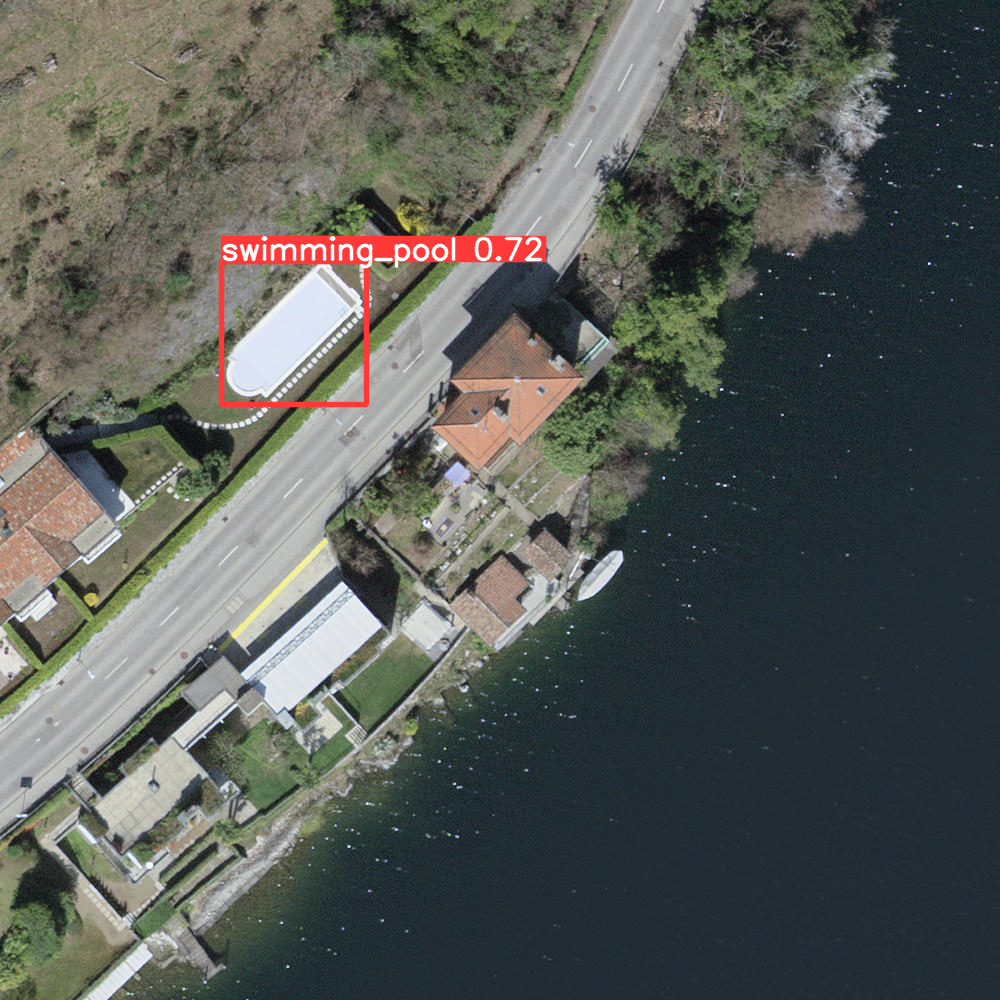

In [3]:
# Test avec image inédite
results = model('../data/img_reduites/1000/27152-10873.tif')
results.show()

### Application à toutes les images téléchargées

In [ ]:
# Préparer les accès aux images
img_path = '../data/img_reduites/1000/'
image_paths = [os.path.join(img_path, fname) for fname in os.listdir('../data/img_reduites/1000/')]

pools_bbox = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax'])

for i in range(0, len(image_paths), 500):
    batch_paths = file_paths[i:i+batch_size]
    batch_results = model(batch_paths)

    for i in range(len(batch_results)):
        df = batch_results.pandas().xyxy[i]
        if df.shape[0] > 0:
            fname = batch_results.files[i]
            x_coords = fname.strip('.jpg').split("-")[0]
            y_coords = fname.strip('.jpg').split("-")[1]

            for row in df.itertuples(index=False, name='Pandas'):
                xmin = x_coords + str(round(row.xmin / 10))
                xmax = x_coords + str(round(row.xmax / 10))
                ymin = y_coords + str(100 - round(row.ymin / 10))
                ymax = y_coords + str(100 - round(row.ymax / 10))

                pool_bbox = pd.DataFrame({'xmin': [xmin], 'ymin': [ymin], 'xmax': [xmax], 'ymax': [ymax]})

                pools_bbox = pd.concat([pools_bbox, pool_bbox], ignore_index=True)


In [138]:


for i in range(len(results)):
    df = results.pandas().xyxy[i]
    if df.shape[0] > 0:
        fname = results.files[i]
        x_coords = fname.strip('.jpg').split("-")[0]
        y_coords = fname.strip('.jpg').split("-")[1]

        for row in df.itertuples(index=False, name='Pandas'):
            xmin = x_coords + str(round(row.xmin / 10))
            xmax = x_coords + str(round(row.xmax / 10))
            ymin = y_coords + str(100 - round(row.ymin / 10))
            ymax = y_coords + str(100 - round(row.ymax / 10))

            pool_bbox = pd.DataFrame({'xmin': [xmin], 'ymin': [ymin], 'xmax': [xmax], 'ymax': [ymax]})

            pools_bbox = pd.concat([pools_bbox, pool_bbox], ignore_index=True)
    

In [139]:
pools_bbox

,xmin,ymin,xmax,ymax
0,2498082,1114072,2498091,1114062
1,2498037,1114024,2498046,1114015
2,2715222,1087374,2715237,1087360


In [141]:
pools_bbox.to_csv('../data/detected_pools_bbox.csv', index=False)

In [87]:
imgs = ['../data/img_reduites/1000/24980-11140.tif', '../data/img_reduites/1000/27152-10873.tif', '../data/img_reduites/1000/27152-10872.tif']

results = model(imgs)
results.files


['24980-11140.jpg', '27152-10873.jpg', '27152-10872.jpg']

In [140]:
52000*.5/60

433.3333333333333

In [36]:
for rslt in results.pandas().xyxy:
    print(rslt.xmin)
    print("T")

0    817.278198
1    371.219025
Name: xmin, dtype: float64
T
